In [1]:
import numpy as np
from array import array
import os
import sys
import ROOT
from ROOT import TVectorD, TMatrix, TMath, TVector3, TGraphErrors, TFile, TTree, gRandom, gPad, gROOT, gVirtualX, kTRUE, kRed, TProfile, gStyle,  TFile, gSystem
from fastSimulation import *

Welcome to JupyROOT 6.22/02


Warning in <TClassTable::Add>: class ROOT::VecOps::RVec<int> already in TClassTable
Warning in <TClassTable::Add>: class ROOT::VecOps::RVec<float> already in TClassTable


# Reading the files

In [2]:
folder="${fastMCKalmanOptTesting}/data/testTPCmuons/fixedpt20/MC_01smear_Eloss_MS_Seed_Eloss_MS_Kalman_Eloss_MS/"
#folder="/home/federico/Documents/Universita/Federico_2020-2021/Aliwork/fastMCKalman/data/testTPCSA/"
inputData = folder+"fastParticle.list"
ROOT.initTreeFast(inputData)
tree=ROOT.treeFast
treeSeed = ROOT.treeSeed


Number of entries	1
0	0	/home/federico/Documents/Universita/Federico_2020-2021/Aliwork/fastMCKalmanOptTesting/data/testTPCmuons/fixedpt20/MC_01smear_Eloss_MS_Seed_Eloss_MS_Kalman_Eloss_MS/MC_01smear_Eloss_MS_Seed_Eloss_MS_Kalman_Eloss_MS.root
Number of entries	1
0	0	/home/federico/Documents/Universita/Federico_2020-2021/Aliwork/fastMCKalmanOptTesting/data/testTPCmuons/fixedpt20/MC_01smear_Eloss_MS_Seed_Eloss_MS_Kalman_Eloss_MS/MC_01smear_Eloss_MS_Seed_Eloss_MS_Kalman_Eloss_MS.root
Number of entries	1
0	0	/home/federico/Documents/Universita/Federico_2020-2021/Aliwork/fastMCKalmanOptTesting/data/testTPCmuons/fixedpt20/MC_01smear_Eloss_MS_Seed_Eloss_MS_Kalman_Eloss_MS/MC_01smear_Eloss_MS_Seed_Eloss_MS_Kalman_Eloss_MS.root
Number of entries	1
0	0	/home/federico/Documents/Universita/Federico_2020-2021/Aliwork/fastMCKalmanOptTesting/data/testTPCmuons/fixedpt20/MC_01smear_Eloss_MS_Seed_Eloss_MS_Kalman_Eloss_MS/MC_01smear_Eloss_MS_Seed_Eloss_MS_Kalman_Eloss_MS.root


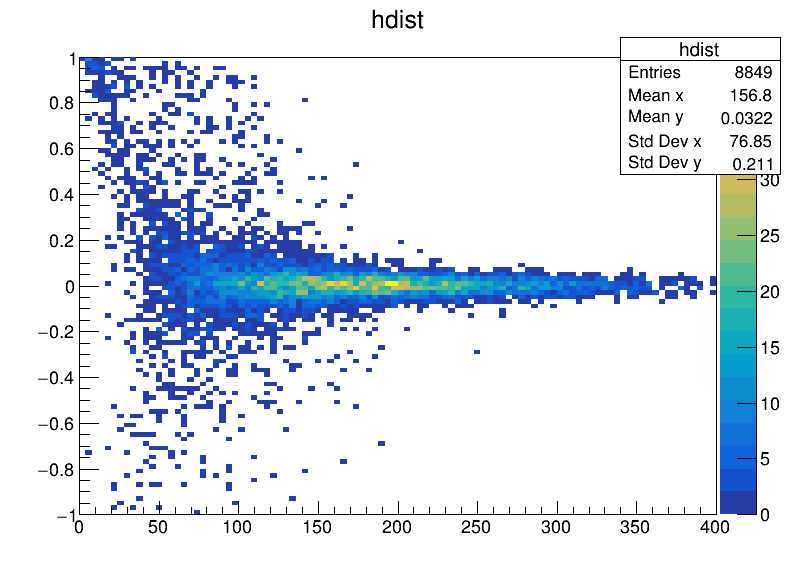

In [3]:
hdist = ROOT.TH2D("hdist","hdist",100,0,400,100,-1,1)

for iev in range(tree.GetEntries()):
    tree.GetEntry(iev)
    #print("entry number: ",str(iev))
    if (tree.part.fStatusMaskIn[1]!=31 or tree.part.fParamMC.size()==0): continue

    xyz_st = [tree.part.fParamMC[1].GetX(),tree.part.fParamMC[1].GetParameter()[0],tree.part.fParamMC[1].GetParameter()[1]]
    alpha_st = tree.part.fParamMC[1].GetAlpha()
    xyz_gl_st = [xyz_st[0]*np.cos(alpha_st)-xyz_st[1]*np.sin(alpha_st), xyz_st[0]*np.sin(alpha_st)+xyz_st[1]*np.cos(alpha_st), xyz_st[2]]
    x_g = xyz_gl_st[0]
    y_g = xyz_gl_st[1]
    length=0

    

    for i in range(2,tree.part.fParamMC.size()):
        xyz = [tree.part.fParamMC[i].GetX(),tree.part.fParamMC[i].GetParameter()[0],tree.part.fParamMC[i].GetParameter()[1]]
        alpha = tree.part.fParamMC[i].GetAlpha()
        xyz_gl = [xyz[0]*np.cos(alpha)-xyz[1]*np.sin(alpha), xyz[0]*np.sin(alpha)+xyz[1]*np.cos(alpha), xyz[2]]
        d = np.sqrt(np.square(xyz_gl[0]-xyz_gl_st[0])+np.square(xyz_gl[1]-xyz_gl_st[1])+np.square(xyz_gl[2]-xyz_gl_st[2]))
        length=length+d
        #print(xyz,alpha,length)
        if(np.abs(xyz[0])==250 or tree.part.fLoop[i]==1): break
        xyz_gl_st=xyz_gl
        alpha_st=alpha
    
    res=(tree.part.fParamMC[1].GetP()-tree.part.fParamIn[1].GetP())/tree.part.fParamMC[1].GetP()
    hdist.Fill(length,res)

cp = ROOT.TCanvas("myCanvasNamep","The Canvas Titlep",800,600)
hdist.Draw("COLZ")
cp.Draw()

        
        

0 12
12 25
25 37
37 50
50 62
62 75
75 87
87 100
 FCN=124.579 FROM MIGRAD    STATUS=CONVERGED     154 CALLS         155 TOTAL
                     EDM=1.06177e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     6.95190e+00   3.30503e+00   2.14570e-03  -2.29108e-03
   2  Mean         1.49599e+00   1.09097e+00   3.31098e-04   6.56078e-03
   3  Sigma        1.15617e+00   4.70840e-01   1.13938e-04   1.14764e-03
 FCN=342.598 FROM MIGRAD    STATUS=CONVERGED      98 CALLS          99 TOTAL
                     EDM=1.82042e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     5.99153e+01   3.28891e+00   1.58840e-02   1.02910e-04
   2  Mean         1.79814e-02   4.54697e-03   4.11544e-05

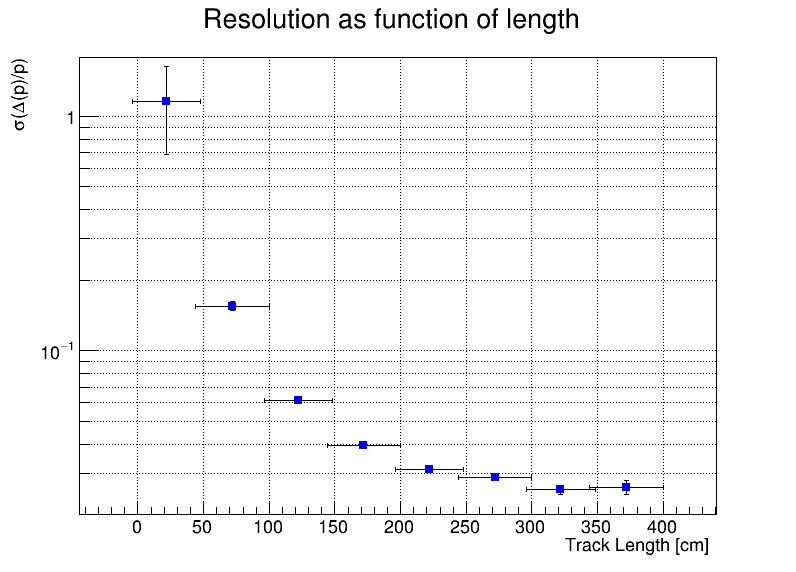

In [4]:
x = array('d')
y = array('d')
ex = array('d')
ey = array('d')
npoints = 8

for d in range(0,npoints):
     low = int((d)*hdist.GetNbinsX()/npoints)
     high = int((d+1)*hdist.GetNbinsX()/npoints)
     lowloc = hdist.GetXaxis().GetBinLowEdge(low)
     highloc = hdist.GetXaxis().GetBinLowEdge(high+1)
     print(low,high)
     histo = hdist.ProjectionY("histoproj_"+str(d),low,high)
     fun = ROOT.TF1("f_"+str(d),"gaus")
     histo.Fit("f_"+str(d))
     y.append(fun.GetParameter(2))
     ey.append(fun.GetParError(2))
     x.append((lowloc+highloc)/2)
     ex.append(np.abs(lowloc-highloc)/2)

graph = ROOT.TGraphErrors(len(x),x,y,ex,ey)


hq = ROOT.TCanvas("hq","hq",800,600)
hq.SetGrid()
hq.SetLogy()
graph.SetTitle("Resolution as function of length;Track Length [cm];#sigma(#Delta(p)/p)")
graph.SetMarkerColor(4)
graph.SetMarkerSize(1)
graph.SetMarkerStyle(21)         
graph.GetHistogram().SetMinimum(0.02)  #   Y
graph.Draw("AP")
hq.Draw()
